## Imports

In [14]:
!pip install pymoo


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# IMPORTS
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.termination.default import DefaultMultiObjectiveTermination
from tensorflow.keras.models import clone_model
from pymoo.core.problem import Problem
from keras.utils import to_categorical


## Classes

In [16]:
# CLASSES

class Server:
    def __init__(self, devices_list):
        self.model = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list

    # def evaluate(self, verbose = 1):
    #     test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
    #     return test_loss, test_acc

    def evaluate(self, x_test=None, y_test=None, verbose = 1):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model():
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(self, lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(self.multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_weights_all_layers = []
        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            device_weights_all_layers.append(device.model.get_weights())
            print("*******************")
            print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            print("this device's participation ratio:")
            print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            print("this device's data to all ratio:")
            print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        # new
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]



        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(self, selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self, selected_devices[d].model.get_weights(), normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        print("Aggregated weights:")
        for layer_idx, layer_weights in enumerate(aggregated_weights):
            print(f"Layer {layer_idx}: {layer_weights.shape}")
        return aggregated_weights


class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0


class FederatedLearningProblem(Problem):
    def __init__(self, devices, server: Server):
        super().__init__(
            n_var=len(devices),         # Number of variables (bitstring length)
            n_obj=3,                   # Number of objectives
            n_constr=0,                # No constraints
            xl=np.zeros(len(devices)),  # Lower bound (0)
            xu=np.ones(len(devices)),   # Upper bound (1)
            type_var=np.bool_          # Binary variables (bitstrings)
        )
        self.devices = devices
        self.server = server
        self.x_test_global = server.x_test_global
        self.y_test_global = server.y_test_global

        # Save the initial global model weights
        self.initial_global_weights = server.get_weights()

    def _evaluate(self, X, out, *args, **kwargs):
        """Evaluates objective values for each solution in the population."""
        num_solutions = len(X)
        F = np.zeros((num_solutions, 3))  # Initialize objective matrix

        for i, bitstring in enumerate(X):
            # print(f"evaluating: {bitstring}")
            # TODO: check bitstring type
            # Reset the global model to its initial state
            # Update device participation based on the bitstring
            selected_devices = [device for device, bit in zip(self.devices, bitstring) if int(bit) == 1]

            # Objective 1: Hardware Objectives (maximize)
            hardware_score = 0.0
            for device in selected_devices:
                device_hardware_score = float(6 - (device.ram + device.storage + device.cpu + device.bandwidth + device.battery + device.charging)) / 6.0
                hardware_score += device_hardware_score

            F[i, 0] = hardware_score  # Minimize (negative of hardware score)

            fairness_score = 0
            for device in self.devices:
                if bitstring[int(device.id)] == 1:
                    # new
                    _, accuracy = self.server.evaluate(device.test_data[0], device.test_data[1], verbose=0)
                    fairness_score += accuracy

            F[i, 1] = fairness_score/float(len(selected_devices))  # Minimize (negative of fairness score)  # Added (/Selected Devices) to normalize between 0 and 1

            # Objective 3: Global Model Accuracy (Performance) (maximize)
            temp_global_model = Server.create_model()
            temp_global_model.set_weights(self.performance_objective_aggregation(selected_devices))
            _, global_accuracy = temp_global_model.evaluate(self.server.x_test_global, self.server.y_test_global, verbose=0)
            F[i, 2] = 1 - global_accuracy  # Minimize (1 - accuracy)

        out["F"] = F  # Set the objective values

    def performance_objective_aggregation(self, selected_devices):

        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_weights_all_layers = []
        device_participation_ratio = []
        # device_participation_weights = []
        data_lengths = []

        for device in selected_devices:
            device_weights_all_layers.append(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)])
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.server.current_learning_iteration)
            # device_participation_weights.append(device.last_round_participated)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.server.current_learning_iteration)

            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        # data_weights = []
        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))
            # data_weights.append(len(device.data[0]))


        # new:
        # weights = []
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]



        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))


        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        # print("Aggregated weights:")
        # for layer_idx, layer_weights in enumerate(aggregated_weights):
        #     print(f"Layer {layer_idx}: {layer_weights.shape}")
        return aggregated_weights




## Functions

In [17]:
# Functions

def fit_bitstring_devices(bitstring, server: Server):
    '''
    server: for using its "current_learning_iteration" variable
    '''
    # print(1)
    # global current_learning_iteration
    # global LAST_WEIGHTS_SENT_FOR_ALL_DEVICES
    server.current_learning_iteration += 1
    for device in server.devices:
        if bitstring[int(device.id)] == 1:
            device.model.fit(device.data[0], device.data[1], epochs=7, verbose=1)
            print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1



## Load Data

### Load Devices

In [18]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

d:\github project\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Object Initializations

In [19]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [20]:
# Load MNIST dataset  # new
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension

# Shuffle data
# indices = np.arange(len(x_train))
# np.random.shuffle(indices)
# x_train, y_train = x_train[indices], y_train[indices]







# new
# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/8)]
y_train = y_train[:int(len(y_train)/8)]







# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
num_devices = len(devices)
split_size = len(x_train_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_train_devices)
    device.data = (x_train_devices[start:end], y_train_devices[start:end])

# Split test data (device-level)
split_size = len(x_test_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_test_devices)
    device.test_data = (x_test_devices[start:end], y_test_devices[start:end])

### Load Other Data

## First Iteration

In [21]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)

test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0529 - loss: 2.3071
Global Model Accuracy: 0.0510
------------------------------------------------------------
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0747 - loss: 2.2963
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2542 - loss: 2.2283
Epoch 3/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3676 - loss: 2.1751
Epoch 4/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5000 - loss: 2.1058
Epoch 5/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5188 - loss: 2.0580
Epoch 6/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6000 - loss: 1.9562
Epoch 7/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6567 - loss: 1.8531
0.0
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0357 - loss: 2.3130
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1904 - loss: 2.2470
Epo

In [22]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)

test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6735 - loss: 1.8786
Global Model Accuracy: 0.6705
------------------------------------------------------------
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6540 - loss: 1.8870
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7505 - loss: 1.7458
Epoch 3/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7601 - loss: 1.6398
Epoch 4/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7514 - loss: 1.5200
Epoch 5/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7600 - loss: 1.4177
Epoch 6/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8109 - loss: 1.2937
Epoch 7/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8604 - loss: 1.0836
0.0
Epoch 1/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6132 - loss: 1.9141
Epoch 2/7
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7238 - loss: 1.8119
Epo

##### tested til here

In [9]:
!pip install pymoo

## NSGA2 Loop

In [10]:
# Parameters
POPULATION_SIZE = 50
NUM_GENERATIONS = 3
NUM_ROUNDS = 1

In [11]:
# Object Initializations

problem = FederatedLearningProblem(
    devices=devices,
    server=server
)


# Step 2: Configure NSGA-II Algorithm
algorithm = NSGA2(
    pop_size=POPULATION_SIZE,
    sampling=BinaryRandomSampling(),      # Random bitstrings
    crossover=TwoPointCrossover(),        # Two-point crossover
    mutation=BitflipMutation(),           # Bit flip mutation
    eliminate_duplicates=True             # Avoid duplicate solutions
)


In [12]:
# DEBUG:
print(server.x_test_global.shape)
print(server.y_test_global.shape)

print(x_train.shape)
print(y_train.shape)

(2000, 28, 28, 1)
(2000, 10)
(60000, 28, 28, 1)
(60000, 10)


In [13]:
from pymoo.core.callback import Callback
import numpy as np

class ParetoLogger(Callback):
    def __init__(self):
        super().__init__()
        self.data["pareto_fronts"] = []     # Objective values F
        self.data["pareto_solutions"] = []  # Decision variables X

    def notify(self, algorithm):
        opt = algorithm.opt
        if opt is not None:
            F = opt.get("F")
            X = opt.get("X")
            self.data["pareto_fronts"].append(F.copy())
            self.data["pareto_solutions"].append(X.copy())



In [14]:
all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

for i in range(NUM_ROUNDS):
    # Step 3: Run Optimization
    print("GLOBAL MODEL BEFORE OPTIMIZATION")
    print(server.evaluate())

    callback = ParetoLogger()
    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=DefaultMultiObjectiveTermination(n_max_gen=NUM_GENERATIONS),
        # seed=42,
        verbose=True,
        callback=callback
    )
    print("GLOBAL MODEL AFTER OPTIMIZATION")
    print(server.evaluate())


    # Step 4: Extract the Best Pareto Front
    pareto_front = res.F   # Objective values of solutions in Pareto front
    pareto_solutions = res.X  # Corresponding bitstrings

    # Print the Best Pareto Front Solutions
    print("Best Pareto Front (Bitstrings):")
    for bitstring in pareto_solutions:
        print("".join(map(str, bitstring)).replace('True','1').replace('False','0'))

    bitstring = pareto_solutions[0] # for now!
    bitstring = str(bitstring).replace('False','0').replace('True','1')
    for char in bitstring:
        if char != '0' and char != '1':
            bitstring = bitstring.replace(char,'')

    print(len(bitstring))
    print(bitstring)
    temp_bitstring = []
    for bit in bitstring:
        temp_bitstring.append(bit)
    bitstring = temp_bitstring


    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")
    print("------------------------------------------------------------")
    print(server.current_learning_iteration, " 1")
    server.give_global_model_weights_to_bitstring_devices(bitstring)
    print(server.current_learning_iteration, " 2")
    fit_bitstring_devices(bitstring, server=server)
    print(server.current_learning_iteration, " 3")
    server.model.set_weights(server.aggregate_weights(bitstring))
    print(server.current_learning_iteration, " 4")
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")

    # Save the pareto fronts from this run
    all_runs_fronts.append(callback.data["pareto_fronts"])
    all_runs_solutions.append(callback.data["pareto_solutions"])


GLOBAL MODEL BEFORE OPTIMIZATION
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.2377
(0.29238346219062805, 0.9279999732971191)
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      7 |             - |             -
     2 |      100 |     12 |  0.3330697014 |         nadir
     3 |      150 |     25 |  0.1055503254 |         ideal
GLOBAL MODEL AFTER OPTIMIZATION
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9439 - loss: 0.2377
(0.29238346219062805, 0.9279999732971191)
Best Pareto Front (Bitstrings):
111111101100000010100000000010
010000000000110100101000010000
000100100000000110101111010001
000111101001100010110011000010
011100000001011110100010010001
111111101100001010100100000010
110010110101100010100000000001
000100100000000110100100010001
000001101001100010110011010001
001010111110000100100010010001
101111101100000010100110000010
000100111000000110001111010001
000100100000000001001100010001
10001011111100011000011100

[[array([[ True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False, False, False, False, False, False,  True, False,
         True, False, False, False, False, False, False, False, False,
        False,  True, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False,  True, False, False,
         True, False,  True, False, False, False, False,  True, False,
        False, False, False],
       [False, False, False,  True, False, False,  True, False, False,
        False, False, False, False, False, False,  True,  True, False,
         True, False,  True,  True,  True,  True, False,  True, False,
        False, False,  True],
       [False, False, False, False, False,  True,  True, False, False,
         True,  True, False, False, False, False,  True,  True,  True,
        False, False,  True, False,  True,  True, False, False, False,
        False, False,  True],
       [False, False, Fals

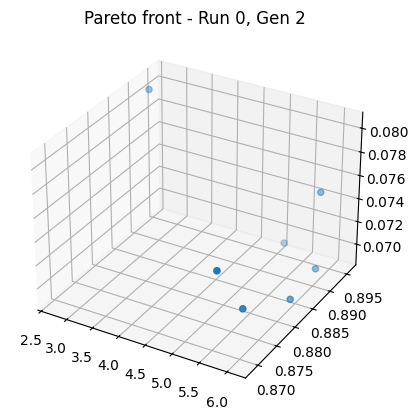

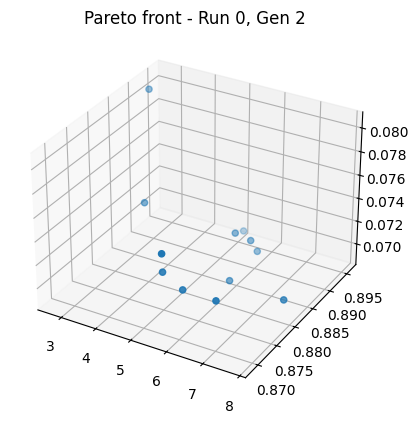

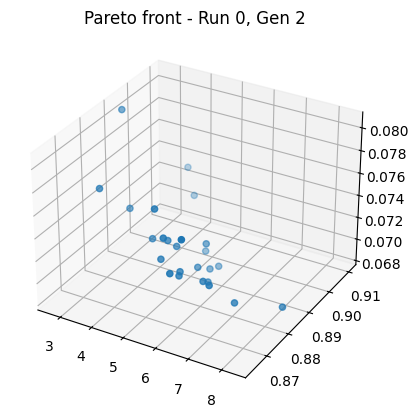

In [15]:
import matplotlib.pyplot as plt

print(all_runs_solutions)
print(len(all_runs_solutions))
print(all_runs_fronts)

# Example: visualize the Pareto front from generation 2 of run 0 (if 3 objectives)
front = all_runs_fronts[0][0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(front[:,0], front[:,1], front[:,2])
ax.set_title("Pareto front - Run 0, Gen 2")
plt.show()

front = all_runs_fronts[0][1]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(front[:,0], front[:,1], front[:,2])
ax.set_title("Pareto front - Run 0, Gen 2")
plt.show()

front = all_runs_fronts[0][2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(front[:,0], front[:,1], front[:,2])
ax.set_title("Pareto front - Run 0, Gen 2")
plt.show()

In [16]:
# Step 4: Extract the Best Pareto Front
pareto_front = res.F   # Objective values of solutions in Pareto front
pareto_solutions = res.X  # Corresponding bitstrings

# Print the Best Pareto Front Solutions
print("Best Pareto Front (Bitstrings):")
for bitstring in pareto_solutions:
    print("".join(map(str, bitstring)).replace('True','1').replace('False','0'))

bitstring = pareto_solutions[0] # for now!
bitstring = str(bitstring).replace('False','0').replace('True','1')
for char in bitstring:
    if char != '0' and char != '1':
        bitstring = bitstring.replace(char,'')

print(len(bitstring))
print(bitstring)
temp_bitstring = []
for bit in bitstring:
    temp_bitstring.append(bit)
bitstring = temp_bitstring

########################################################

Best Pareto Front (Bitstrings):
111111101100000010100000000010
010000000000110100101000010000
000100100000000110101111010001
000111101001100010110011000010
011100000001011110100010010001
111111101100001010100100000010
110010110101100010100000000001
000100100000000110100100010001
000001101001100010110011010001
001010111110000100100010010001
101111101100000010100110000010
000100111000000110001111010001
000100100000000001001100010001
100010111111000110000111000001
000001111001011110100001000001
100110110100101100000000100100
000101100000000110101111010001
000111101001100010010011000010
000001010001100000011001000001
111000010101100010100000000100
001001010001000110110011010000
010001111011001011011110100001
010101100011010000100010000001
000000100100100100100010000001
010110111111101100000010010000
30
111111101100000010100000000010
